# IFT870 - TP1 
### gibg2501 - leba3207
#### 7 février 2020

In [1]:
# some imports...
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
from mpl_toolkits.mplot3d import Axes3D

import scipy.spatial.distance as sdist
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Magical word to inline figures in jupyter notebook
%matplotlib notebook

# Disable annoyin warnings
import warnings
warnings.filterwarnings('ignore')

# removes maximum number of columns & rows for display
pd.options.display.max_columns = 7
pd.options.display.max_rows = 10

# Determine how many outputs per cells should be displayed
InteractiveShell.ast_node_interactivity = "last_expr" #    'all', 'last', 'last_expr', 'none', 'last_expr_or_assign'

# Loads the data in a data frame
tp1_data_file = 'TP1_data.csv'
tp1_data = pd.read_csv(tp1_data_file, header=0, index_col=0)
tp1_data
headers = tp1_data.columns

# Create data frames for each classe
condition0 = tp1_data['classe'] == 0
condition1 = tp1_data['classe'] == 1
condition2 = tp1_data['classe'] == 2

tp1_data_classe_0 = tp1_data.loc[condition0 , 'attribut1':'attribut4']
tp1_data_classe_1 = tp1_data.loc[condition1 , 'attribut1':'attribut4']
tp1_data_classe_2 = tp1_data.loc[condition2 , 'attribut1':'attribut4']

Description des données statistiques de base du jeux de données

In [2]:
tp1_data.loc[:, 'attribut1':'attribut4'].describe()

,attribut1,attribut2,attribut3,attribut4
count,59.000000,59.000000,59.000000,59.000000
mean,49.793220,23.486441,9.594915,14.557627
std,10.490782,3.531995,8.174992,4.057994
min,28.700000,16.500000,0.000000,3.700000
25%,40.850000,21.050000,2.400000,12.000000
50%,49.000000,23.300000,9.000000,15.100000
75%,59.200000,25.100000,13.000000,16.950000
max,68.500000,33.000000,29.100000,23.000000


# 1. Représentation des données

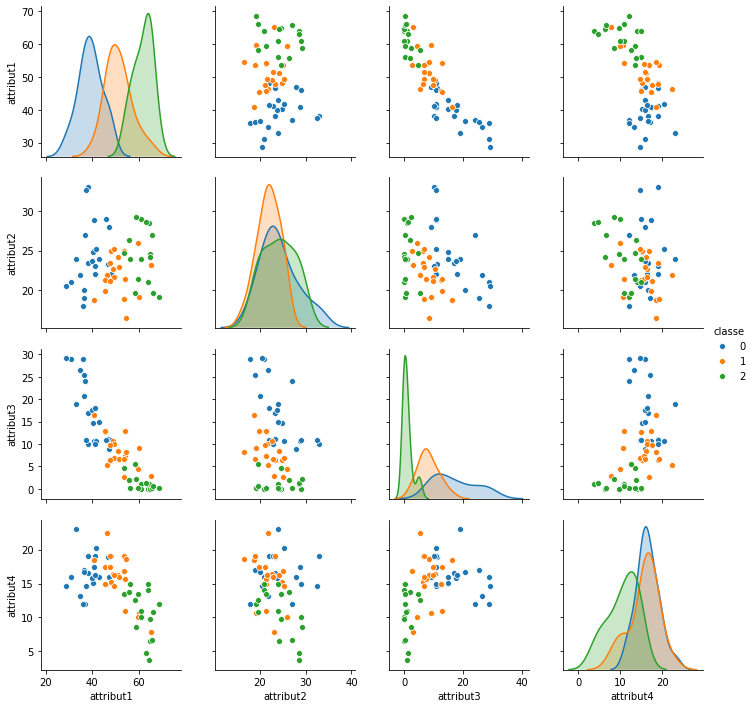

In [3]:
%matplotlib inline
sns.pairplot(tp1_data, vars=['attribut1', 'attribut2', 'attribut3', 'attribut4'],  hue='classe')

Affichage des attributs du jeux de données paire à paire et quantification de la correlation à l'aide de la méthode de Pearson $$\left(\frac{cov(X,Y)}{\sigma_X\sigma_Y} \right)$$

Les attributs 1 et 3 semblent corrélés. On peut le confirmer quantitativement avec une mesure de corrélation de Pearson.

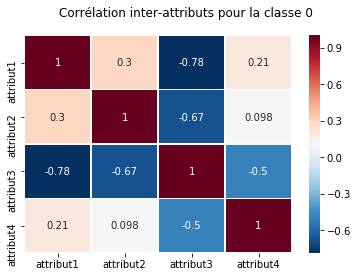

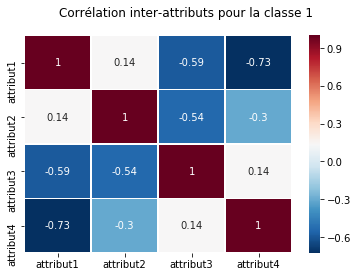

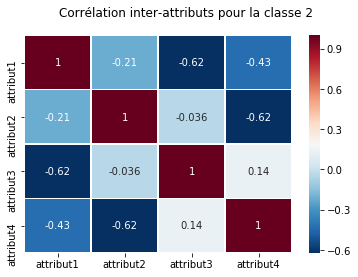

In [4]:
correlations = [tp1_data_classe_0.corr(method='pearson'), tp1_data_classe_1.corr(method='pearson'), tp1_data_classe_2.corr(method='pearson')]
for i, c in enumerate(correlations):
    plt.figure(i)
    plt.suptitle("Corrélation inter-attributs pour la classe %i" %i)
    sns.heatmap(c, xticklabels=c.columns, yticklabels=c.columns,
                cmap='RdBu_r', annot=True, linewidth=0.5)
    plt.show()

On peut confirmer avec ces graphes qu'il y a effectivement une corrélation entre les attributs 1 et 3 pour les 3 classes. 

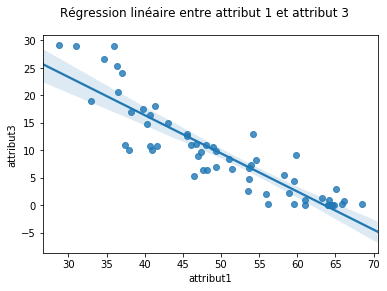

In [5]:
sns.regplot(tp1_data.loc[:,'attribut1'],tp1_data.loc[:,'attribut3'])
plt.suptitle("Régression linéaire entre attribut 1 et attribut 3")
plt.show()

### Transformation ACP
Utilisation de la méthode de réduction en composantes principales ($\textit{PCA}$) pour quantifier les corrélations entre les attributs pour chaque classe

In [6]:
# Scale the features data and applies PCA tranform for all classes
# Scaling
scaler = StandardScaler()
features = tp1_data.loc[: , 'attribut1':'attribut4']
labels = tp1_data.loc[: , 'classe']
scaler.fit(features)
tp1_data_scaled = scaler.transform(features)

# PCA transform on scaled data
PCA_scaled___data_tp1 = PCA(n_components = features.shape[1])
PCA_scaled___data_tp1.fit(tp1_data_scaled, labels)
transf___scaled_all = PCA_scaled___data_tp1.transform(tp1_data_scaled)

# PCA transform on centered data
PCA_centered_data_tp1 = PCA(n_components = features.shape[1])
PCA_predict = PCA(n_components = 3)
# Center features around 0
centered_features = features - np.mean(features)
PCA_centered_data_tp1.fit(features, labels)
PCA_predict.fit(features, labels)
transf_centered_all = PCA_centered_data_tp1.transform(features)

# Create data frames from transformed features
transf___scaled_all_labeled = pd.DataFrame(transf___scaled_all, columns = ['attribut1', 'attribut2', 'attribut3', 'attribut4'])
transf___scaled_all_labeled.insert(4, 'classe', labels.array)

transf_centered_all_labeled = pd.DataFrame(transf_centered_all, columns = ['attribut1', 'attribut2', 'attribut3', 'attribut4'])
transf_centered_all_labeled.insert(4, 'classe', labels.array)

# Create data frame from PCs
data_tp1_components = pd.DataFrame(PCA_centered_data_tp1.components_, columns=list(features.columns))
tp1_components_ratios = PCA_centered_data_tp1.explained_variance_ratio_

Les ratios d\'influence pour chaque composante principale: 

In [7]:
tp1_components_ratios

array([0.8418103 , 0.08441998, 0.06948166, 0.00428806])

On peut constater que les composante 1, 2 et 3 sont conjointement responsables d\'environ 92% de la variance des données. On peut donc se défausser de la composante 4.

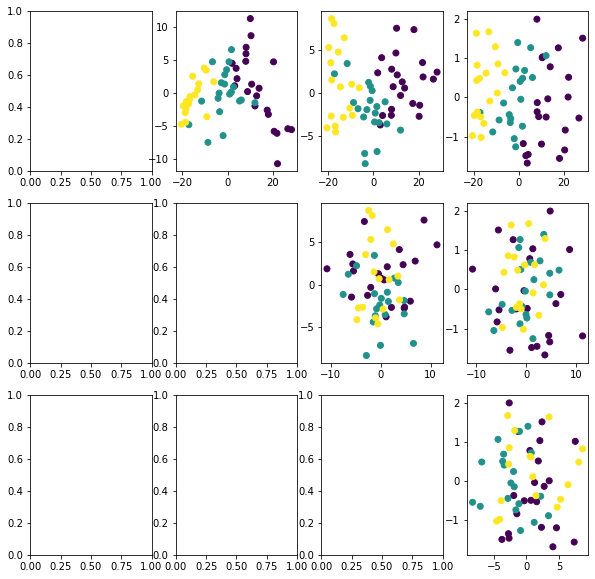

In [8]:
# Dipslay transformed features in 2D
n_features = features.shape[1]
fig, axes = plt.subplots(n_features - 1, n_features, figsize=(10,10))
k = 0
for i in range(n_features):
    for j in range(n_features):
        if(i<j):
            axes[i,j].scatter(transf_centered_all[:, i], transf_centered_all[:, j], c = labels)
        k += 1

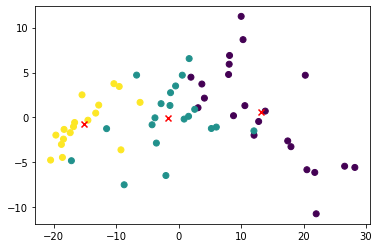

In [9]:
# Calculate ranges and create data frames for each class
lim_inf = 0
lim_1 = tp1_data_classe_0.shape[0]
lim_2 = lim_1 + tp1_data_classe_1.shape[0]
lim_3 = lim_2 + tp1_data_classe_2.shape[0]

transf_C0 = pd.DataFrame(transf_centered_all[lim_inf:lim_1, :], columns = headers[0:4]) 
transf_C1 = pd.DataFrame(transf_centered_all[lim_1:lim_2, :], columns = headers[0:4])
transf_C2 = pd.DataFrame(transf_centered_all[lim_2:, :], columns = headers[0:4])

# Process clusterixng for each class
centroids_C0 = transf_C0.mean(axis=0)[0:3]
centroids_C1 = transf_C1.mean(axis=0)[0:3]
centroids_C2 = transf_C2.mean(axis=0)[0:3]

centroids = np.array([centroids_C0, centroids_C1, centroids_C2])

# Plot transformed features data according to the 2 best PC
plt.scatter(transf_centered_all[:, 0], transf_centered_all[:, 1], c = labels)

# Plots centroids
plt.scatter(centroids_C0[0], centroids_C0[1], marker='x', c='r')
plt.scatter(centroids_C1[0], centroids_C1[1], marker='x', c='r')
plt.scatter(centroids_C2[0], centroids_C2[1], marker='x', c='r')

In [10]:
def GetEuclidianDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    for index, transf_point in transformed_values_labelled.iterrows():

        if n_pc == 2:
            _dist_c0 = sdist.euclidean([transf_point[0], transf_point[1]],
                                       [centroids_arr [0, 0], centroids_arr [0, 1]])

            _dist_c1 = sdist.euclidean([transf_point[0], transf_point[1]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1]])

            _dist_c2 = sdist.euclidean([transf_point[0], transf_point[1]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1]])
        elif n_pc == 3:
            _dist_c0 = sdist.euclidean([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1], centroids_arr [0, 2]])

            _dist_c1 = sdist.euclidean([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1], centroids_arr [1, 2]])

            _dist_c2 = sdist.euclidean([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1], centroids_arr [2, 2]])

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([index, calculated_classe, actual_classe])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

def GetManhattanDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    for index, transf_point in transformed_values_labelled.iterrows():

        if n_pc == 2:
            _dist_c0 = sdist.cityblock([transf_point[0], transf_point[1]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1]])

            _dist_c1 = sdist.cityblock([transf_point[0], transf_point[1]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1]])

            _dist_c2 = sdist.cityblock([transf_point[0], transf_point[1]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1]])
        elif n_pc == 3:
            _dist_c0 = sdist.cityblock([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1], centroids_arr [0, 2]])

            _dist_c1 = sdist.cityblock([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1], centroids_arr [1, 2]])

            _dist_c2 = sdist.cityblock([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1], centroids_arr [2, 2]])

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([index, calculated_classe, actual_classe])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

def GetLocalMahalanobisDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    _min_dist_c0 = np.Infinity
    _min_dist_c1 = np.Infinity
    _min_dist_c2 = np.Infinity

    if n_pc == 2:
        _arr = np.array([transf_C0.loc[:, 'attribut1'], transf_C0.loc[:, 'attribut2']])
        _inv_cov_c0 = np.linalg.inv(np.cov(_arr))
        _arr = np.array([transf_C1.loc[:, 'attribut1'], transf_C1.loc[:, 'attribut2']])
        _inv_cov_c1 = np.linalg.inv(np.cov(_arr))
        _arr = np.array([transf_C2.loc[:, 'attribut1'], transf_C2.loc[:, 'attribut2']])
        _inv_cov_c2 = np.linalg.inv(np.cov(_arr))

    elif n_pc == 3:
        _arr = np.array([transf_C0.loc[:, 'attribut1'], transf_C0.loc[:, 'attribut2'], transf_C0.loc[:, 'attribut3']])
        _inv_cov_c0 = np.linalg.inv(np.cov(_arr))
        _arr = np.array([transf_C1.loc[:, 'attribut1'], transf_C1.loc[:, 'attribut2'], transf_C1.loc[:, 'attribut3']])
        _inv_cov_c1 = np.linalg.inv(np.cov(_arr))
        _arr = np.array([transf_C2.loc[:, 'attribut1'], transf_C2.loc[:, 'attribut2'], transf_C2.loc[:, 'attribut3']])
        _inv_cov_c2 = np.linalg.inv(np.cov(_arr))

    for index, transf_point in transformed_values_labelled[transformed_values_labelled.classe == 0].iterrows():
        if n_pc == 2:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[0, 0], centroids_arr[0, 1]], _inv_cov_c0)
            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[1, 0], centroids_arr[1, 1]], _inv_cov_c0)
            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[2, 0], centroids_arr[2, 2]], _inv_cov_c0)

        elif n_pc == 3:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[0, 0], centroids_arr[0, 1], centroids_arr[0, 2]], _inv_cov_c0)
            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr[1, 0], centroids_arr[1, 1], centroids_arr[1, 2]], _inv_cov_c0)
            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr[2, 0], centroids_arr[2, 1], centroids_arr[2, 2]], _inv_cov_c0)

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([int(index), int(calculated_classe), int(actual_classe)])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    for index, transf_point in transformed_values_labelled[transformed_values_labelled.classe == 1].iterrows():
        if n_pc == 2:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[0, 0], centroids_arr[0, 1]], _inv_cov_c1)
            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[1, 0], centroids_arr[1, 1]], _inv_cov_c1)
            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[2, 0], centroids_arr[2, 1]], _inv_cov_c1)

        elif n_pc == 3:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[0, 0], centroids_arr[0, 1], centroids_arr[0, 2]], _inv_cov_c1)
            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[1, 0], centroids_arr[1, 1], centroids_arr[1, 2]], _inv_cov_c1)
            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[2, 0], centroids_arr[2, 1], centroids_arr[2, 2]], _inv_cov_c1)

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([int(index), int(calculated_classe), int(actual_classe)])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    for index, transf_point in transformed_values_labelled[transformed_values_labelled.classe == 2].iterrows():
        if n_pc == 2:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[0, 0], centroids_arr[0, 1]], _inv_cov_c2)
            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[1, 0], centroids_arr[1, 1]], _inv_cov_c2)
            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                         [centroids_arr[2, 0], centroids_arr[2, 1]], _inv_cov_c2)

        elif n_pc == 3:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[0, 0], centroids_arr[0, 1], centroids_arr[0, 2]], _inv_cov_c2)
            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[1, 0], centroids_arr[1, 1], centroids_arr[1, 2]], _inv_cov_c2)
            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                         [centroids_arr[2, 0], centroids_arr[2, 1], centroids_arr[2, 2]], _inv_cov_c2)

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([int(index), int(calculated_classe), int(actual_classe)])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

def GetGlobalMahalanobisDistancesErrors(transformed_values_labelled, centroids_arr, n_pc):
    _errors_vect = np.array([])
    _err_count = 0

    if n_pc == 2:
        _arr = np.array([transformed_values_labelled.loc[:,'attribut1'],transformed_values_labelled.loc[:,'attribut2']])
        _inv_cov = np.linalg.inv(np.cov(_arr))
    elif n_pc ==3:
        _arr = np.array([transformed_values_labelled.loc[:,'attribut1'],transformed_values_labelled.loc[:,'attribut2'],transformed_values_labelled.loc[:,'attribut3']])
        _inv_cov = np.linalg.inv(np.cov(_arr))

    for index, transf_point in transformed_values_labelled.iterrows():

        if n_pc == 2:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1]], _inv_cov)

            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1]], _inv_cov)

            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1]], _inv_cov)
        elif n_pc == 3:
            _dist_c0 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [0, 0], centroids_arr [0, 1], centroids_arr [0, 2]], _inv_cov)

            _dist_c1 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [1, 0], centroids_arr [1, 1], centroids_arr [1, 2]], _inv_cov)

            _dist_c2 = sdist.mahalanobis([transf_point[0], transf_point[1], transf_point[2]],
                                        [centroids_arr [2, 0], centroids_arr [2, 1], centroids_arr [2, 2]], _inv_cov)

        distances = np.array([_dist_c0, _dist_c1, _dist_c2])

        calculated_classe = np.where(distances == np.amin(distances))[0][0]
        actual_classe = transf_point.loc['classe']

        if calculated_classe != actual_classe:
            _err = np.array([int(index), int(calculated_classe), int(actual_classe)])
            _errors_vect = np.concatenate((_errors_vect, _err))
            _err_count += 1

    _errors_vect = _errors_vect.reshape(_err_count, 3)
    _errors_frame = pd.DataFrame(_errors_vect, columns=['index', 'calculated class', 'acutal class'])
    return _errors_frame

Erreur de classification en utilisant la distance euclidienne et 3 composantes principales:

In [11]:
euclid_dist_errors_3PC = GetEuclidianDistancesErrors(transf_centered_all_labeled, centroids, 3)
euclid_dist_errors_3PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,9.0,1.0,0.0
2,16.0,1.0,0.0
3,17.0,1.0,0.0
4,25.0,2.0,1.0
5,29.0,2.0,1.0
6,30.0,2.0,1.0
7,32.0,0.0,1.0
8,50.0,1.0,2.0


Erreur de classification en utilisant la distance euclidienne et 2 composantes principales:

In [12]:
euclid_dist_errors_2PC = GetEuclidianDistancesErrors(transf_centered_all_labeled, centroids, 2)
euclid_dist_errors_2PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,9.0,1.0,0.0
2,16.0,1.0,0.0
3,17.0,1.0,0.0
4,25.0,2.0,1.0
5,29.0,2.0,1.0
6,30.0,2.0,1.0
7,32.0,0.0,1.0
8,35.0,0.0,1.0
9,50.0,1.0,2.0


L'utilisation d'une transformation avec 3 composantes principales produit 1 erreur de classification de moins que la transformation avec 2 composantes principales. On considère donc l'utilisation de la transformation avec 3 composantes principales pour la suite du travail.

Text(0.5, 0.92, 'Erreurs de classification en utilisant la distance euclidienne')

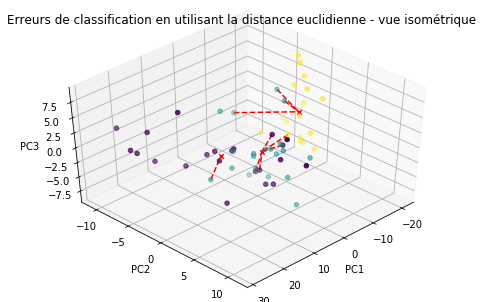

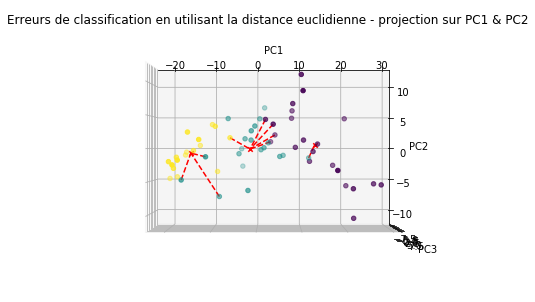

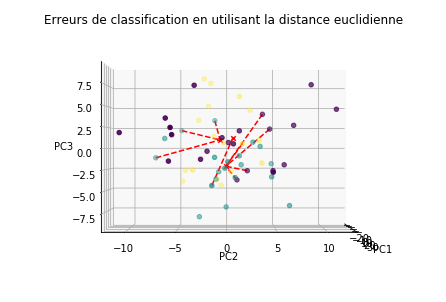

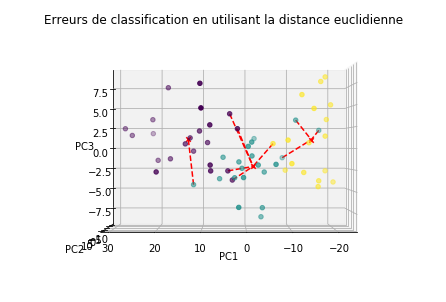

In [13]:
def PlotPC3D(X, Y, Z, elevation, azimut, error_vector):
    fig = plt.figure()
    ax = Axes3D(fig, elev=elevation, azim=azimut)
    ax.scatter(X, Y, Z, c= labels)

    # Plots centroids
    ax.scatter(centroids_C0[0], centroids_C0[1], centroids_C0[2], marker='x', c='r', depthshade=True)
    ax.scatter(centroids_C1[0], centroids_C1[1], centroids_C1[2], marker='x', c='r', depthshade=True)
    ax.scatter(centroids_C2[0], centroids_C2[1], centroids_C2[2], marker='x', c='r', depthshade=True)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    for index, err in error_vector.iterrows():
        err_vec_xs = np.array([transf_centered_all[int(err[0]), 0], centroids[int(err[1]), 0]])
        err_vec_ys = np.array([transf_centered_all[int(err[0]), 1], centroids[int(err[1]), 1]])
        err_vec_zs = np.array([transf_centered_all[int(err[0]), 2], centroids[int(err[1]), 2]])
        ax.plot(err_vec_xs, err_vec_ys, err_vec_zs, 'r--')

    return fig, ax

_, ax1 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 45, 45, euclid_dist_errors_3PC)
_, ax2 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 90, 270, euclid_dist_errors_3PC)
_, ax3 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 0, euclid_dist_errors_3PC)
_, ax4 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 90, euclid_dist_errors_3PC)

ax1.set_title('Erreurs de classification en utilisant la distance euclidienne - vue isométrique')
ax2.set_title('Erreurs de classification en utilisant la distance euclidienne - projection sur PC1 & PC2')
ax3.set_title('Erreurs de classification en utilisant la distance euclidienne')
ax4.set_title('Erreurs de classification en utilisant la distance euclidienne')

# 2. Mesure de distance
## a)

Nous avons pu effectuer les calculs dans le cas de l'utilisation d'une mesure de distance Euclidienne. On s'intéresse maintenant à la mesure de distance Manhattan et Mahalanobis.

### Manhattan 
Erreur de classification en utilisant la distance de manhattan et 3 composantes principales:

In [14]:
manhatan_dist_errors_3PC = GetManhattanDistancesErrors(transf_centered_all_labeled, centroids, 3)
manhatan_dist_errors_3PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,9.0,1.0,0.0
2,16.0,1.0,0.0
3,17.0,1.0,0.0
4,25.0,2.0,1.0
5,29.0,2.0,1.0
6,30.0,2.0,1.0
7,32.0,0.0,1.0
8,50.0,1.0,2.0
9,58.0,1.0,2.0


Erreur de classification en utilisant la distance de manhattan et 2 composantes principales:

In [15]:
manhatan_dist_errors_2PC = GetManhattanDistancesErrors(transf_centered_all_labeled, centroids, 2)
manhatan_dist_errors_2PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,9.0,1.0,0.0
2,16.0,1.0,0.0
3,17.0,1.0,0.0
4,25.0,2.0,1.0
5,29.0,2.0,1.0
6,30.0,2.0,1.0
7,32.0,0.0,1.0
8,50.0,1.0,2.0


### Mahalanobis global

Erreur de classification en utilisant la distance de mahalanobis et 3 composantes principales:

In [16]:
mahalanobis_global_dist_errors_3PC = GetGlobalMahalanobisDistancesErrors(transf_centered_all_labeled, centroids, 3)
mahalanobis_global_dist_errors_3PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,16.0,1.0,0.0
2,18.0,1.0,0.0
3,25.0,2.0,1.0
4,29.0,2.0,1.0
...,...,...,...
7,42.0,1.0,2.0
8,43.0,1.0,2.0
9,49.0,1.0,2.0
10,55.0,1.0,2.0


Erreur de classification en utilisant la distance de mahalanobis et 2 composantes principales:

In [17]:
mahalanobis_global_dist_errors_2PC = GetGlobalMahalanobisDistancesErrors(transf_centered_all_labeled, centroids, 2)
mahalanobis_global_dist_errors_2PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,9.0,1.0,0.0
2,16.0,1.0,0.0
3,17.0,1.0,0.0
4,25.0,2.0,1.0
5,29.0,2.0,1.0
6,30.0,2.0,1.0
7,32.0,0.0,1.0
8,50.0,1.0,2.0
9,51.0,1.0,2.0


Text(0.5, 0.92, 'Erreurs de classification en utilisant la distance Mahalanobis global')

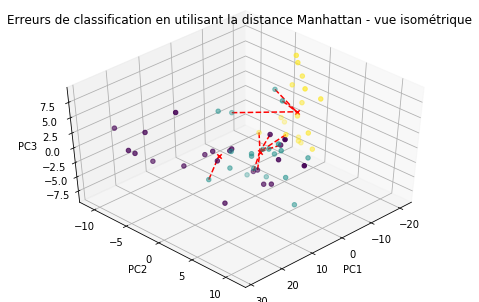

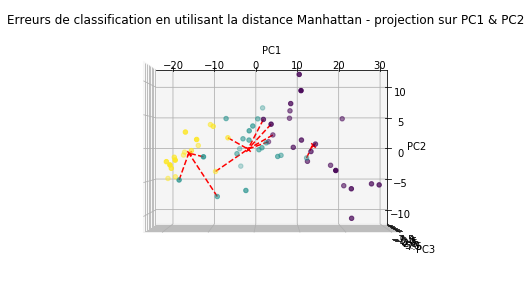

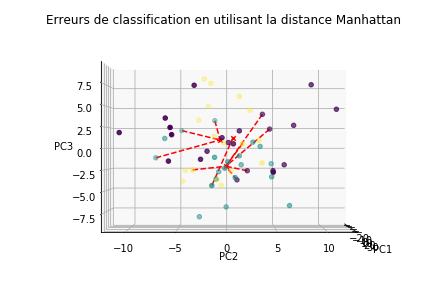

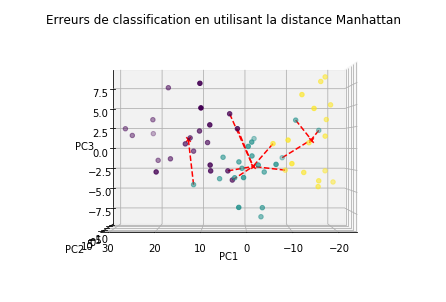

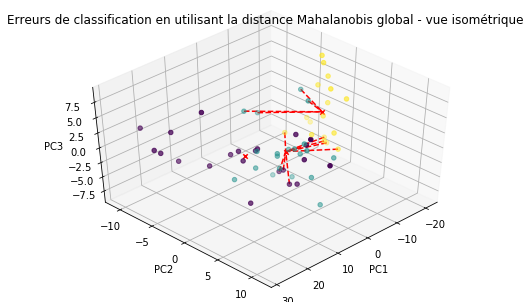

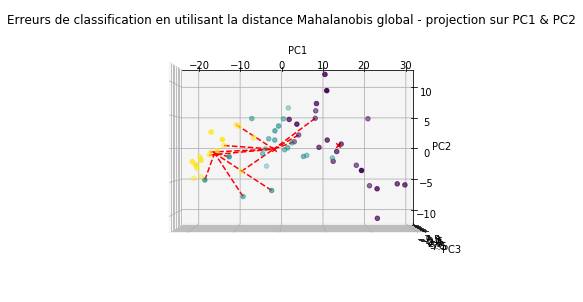

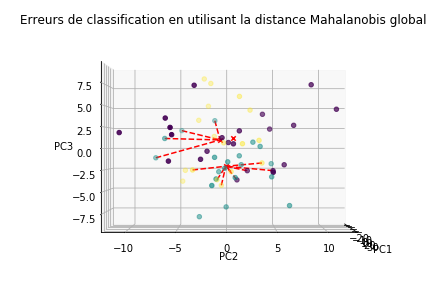

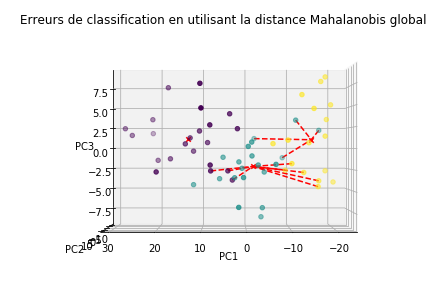

In [18]:
_, ax1 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 45, 45, manhatan_dist_errors_3PC)
_, ax2 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 90, 270, manhatan_dist_errors_3PC)
_, ax3 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 0, manhatan_dist_errors_3PC)
_, ax4 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 90, manhatan_dist_errors_3PC)
ax1.set_title('Erreurs de classification en utilisant la distance Manhattan - vue isométrique')
ax2.set_title('Erreurs de classification en utilisant la distance Manhattan - projection sur PC1 & PC2')
ax3.set_title('Erreurs de classification en utilisant la distance Manhattan')
ax4.set_title('Erreurs de classification en utilisant la distance Manhattan')

_, ax1 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 45, 45, mahalanobis_global_dist_errors_3PC)
_, ax2 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 90, 270, mahalanobis_global_dist_errors_3PC)
_, ax3 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 0, mahalanobis_global_dist_errors_3PC)
_, ax4 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 90, mahalanobis_global_dist_errors_3PC)
ax1.set_title('Erreurs de classification en utilisant la distance Mahalanobis global - vue isométrique')
ax2.set_title('Erreurs de classification en utilisant la distance Mahalanobis global - projection sur PC1 & PC2')
ax3.set_title('Erreurs de classification en utilisant la distance Mahalanobis global')
ax4.set_title('Erreurs de classification en utilisant la distance Mahalanobis global')

Avec l'utilisation de la mesure de distance Mahalanobis, nous observons des erreurs de classification moindres qu'avec la mesure de distance Manhattan. Avec notre jeu de données, cette mesure de distance semble plus approprié.

## b)

Si les distributions des données sont différentes selons les classes, il est plus intéressant de calculer une matrice de covariance pour chaque classe. Nous allons voir maintenant si cela s'applique à notre jeu de données:

In [19]:
mahalanobis_local_dist_errors_3PC = GetLocalMahalanobisDistancesErrors(transf_centered_all_labeled, centroids, 3)
mahalanobis_local_dist_errors_3PC

,index,calculated class,acutal class
0,5.0,1.0,0.0
1,16.0,1.0,0.0
2,29.0,2.0,1.0
3,30.0,2.0,1.0
4,31.0,2.0,1.0
5,32.0,0.0,1.0
6,50.0,1.0,2.0
7,58.0,1.0,2.0


Text(0.5, 0.92, 'Erreurs de classification en utilisant la distance Mahalanobis local')

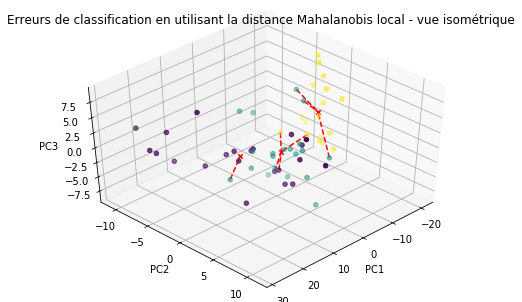

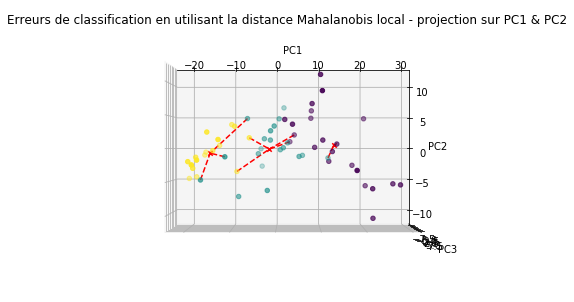

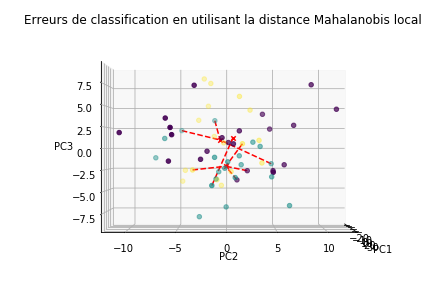

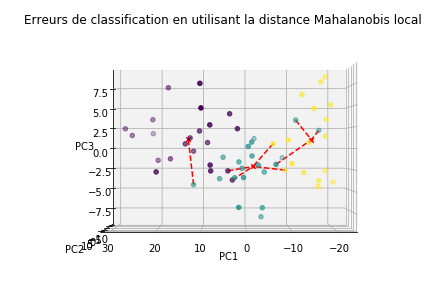

In [20]:
_, ax1 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 45, 45, mahalanobis_local_dist_errors_3PC)
_, ax2 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 90, 270, mahalanobis_local_dist_errors_3PC)
_, ax3 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 0, mahalanobis_local_dist_errors_3PC)
_, ax4 = PlotPC3D(transf_centered_all[:, 0], transf_centered_all[:, 1], transf_centered_all[:, 2], 0, 90, mahalanobis_local_dist_errors_3PC)
ax1.set_title('Erreurs de classification en utilisant la distance Mahalanobis local - vue isométrique')
ax2.set_title('Erreurs de classification en utilisant la distance Mahalanobis local - projection sur PC1 & PC2')
ax3.set_title('Erreurs de classification en utilisant la distance Mahalanobis local')
ax4.set_title('Erreurs de classification en utilisant la distance Mahalanobis local')

Avec l'utilisation d'une matrice de covariance pour chaque classe par la mesure de distance Mahalanobis, nous arrivons à réduire le nombre d'erreurs de classification.

# 3. Choix du modèle de classification
## a)

Aux points précédents, nous avons pu trouver que la meilleure représentation des données est celle avec 3 composantes principales et que la meilleure mesure de distance est la méthode Mahalanobis locale. Nous allons appliquer les modèle k-NN et Nearest Centroid avec ces méthodes.

## k-NN 

In [21]:
transformed_3CP_c = {}
y = tp1_data.classe.copy()
X = tp1_data.drop("classe", 1)
df = pd.concat([X, y], axis=1)

pca_3CP_fit = PCA(n_components=3).fit(X)
pca_3CP_c = []
centroids_3CP = {}
transformed_3CP_c = {}

for y_i in y.unique():
    transformed_3CP_c[y_i] = pca_3CP_fit.transform(df.loc[df['classe'] == y_i].drop('classe', 1))
    centroids_3CP[y_i] = transformed_3CP_c[y_i].mean(axis=0)   
    pca_3CP_c.extend(transformed_3CP_c[y_i])

tranformed_c = transformed_3CP_c

covariance_for_class = {}
for y_i in y.unique():
    covariance_for_class[y_i] = np.linalg.inv(np.cov(tranformed_c[y_i], rowvar=False))

def get_neighbors_knn(train, label, test_row, k_neighbors):
    distances = list()
    for i, train_row in enumerate(train):
        dist = sdist.mahalanobis(train_row, test_row, covariance_for_class.get(label[i]))
        distances.append((label[i], dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors_label = list()
    for i in range(k_neighbors):
        neighbors_label.append(distances[i][0])
    return neighbors_label

In [22]:
pca = np.array(transf_centered_all_labeled.loc[:,'attribut1':'attribut3'])
k=5
nb_iter = 100
scores = 0
for it in range(nb_iter):
    X_train, X_test, y_train, y_test = train_test_split(pca, y, test_size=0.2, stratify=y)
    errors_knn = 0
    for i, x_i_test in enumerate(X_test):
        neighbors_label = get_neighbors_knn(X_train, y_train, x_i_test, k)
        prediction = max(neighbors_label, key=neighbors_label.count)
        if prediction != y_test[i]: errors_knn += 1
    scores += 1 - errors_knn/len(X_test)
print(f"Justesse test {scores/nb_iter:.3%}")

Justesse test 82.750%


## NC

In [23]:
nb_iter = 100
scores = 0
for it in range(nb_iter):
    errors_nc = 0
    X_train, X_test, y_train, y_test = train_test_split(pca, y, test_size=0.2, stratify=y)
    centroids_x_train, cov_matrix_x_train = {}, {}
    for y_i in y_train.unique():
        xx = X_train[y_train == y_i]
        centroids_x_train[y_i] = np.mean(xx, axis=0)
        cov_matrix_x_train[y_i] = np.linalg.inv(np.cov(xx, rowvar=False))

    for i, x_i_test in enumerate(X_test):
        dist = [sdist.mahalanobis(x_i_test, centroids_x_train.get(j), cov_matrix_x_train.get(j)) for j in range(len(centroids_x_train))]
        centroid_label = np.argmin(dist)
        if centroid_label != y_test[i]: 
            errors_nc += 1
    scores += 1 - errors_nc/len(X_test)
print(f"Justesse test {scores/nb_iter:.3%}")


Justesse test 85.833%


On remarque que le modèle Nearest Centroïd donne un score de justesse légèrement supérieur.

## b)

In [29]:
"""
The next section has been adapted from the code available on the Sci-Kit learn web site:
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

Start of adapted section
"""
cov_type = ['full', 'tied', 'diag', 'spherical']
scores_train, scores_test = np.zeros(len(cov_type)), np.zeros(len(cov_type))
    
nb_iter = 10
for it in range(nb_iter):
    X_train, X_test, y_train, y_test = train_test_split(pca, y, test_size=0.2, stratify=y)
    centroids_x_train = []
    for y_i in y_train.unique():
        centroids_x_train.append(np.mean(X_train[y_train == y_i], axis=0))    
        print(centroids_x_train)
        for i, ct in enumerate(cov_type):
            gm = GaussianMixture(n_components=3, covariance_type=ct, means_init = centroids_x_train)
            gm.fit(X_train, y=y_train)
            
            y_train_pred = gm.predict(X_train)
            scores_train[i] += np.mean(y_train_pred == y_train)
            y_test_pred = gm.predict(X_test)
            scores_test[i] += np.mean(y_test_pred == y_test)
            
print("Score de justesse en fonction du type de covariance:")
for i, ct in enumerate(cov_type):
    print(f"{ct} :  entraînement: {scores_train[i]/nb_iter:.3%} - test: {scores_test[i]/nb_iter:.3%}")
train_index, test_index = next(iter(skf.split(transf_centered_all_labeled.loc[:,'attribut1':'attribut2'], transf_centered_all_labeled.loc[:,'classe'])))

[array([-1.91473847, -0.5696665 , -2.16008767])]


ValueError: The parameter 'means' should have the shape of (3, 3), but got (1, 3)

On observe que le type de covariance qui donne des résultats de justesse les plus élevés est le type "tied". Comme on a utlisé la covariance pour chaque classe 

# 4.
Prédiction pour l'observation [52.1, 23.0, 6.1, 16.5]

In [ ]:
observation = [52.1, 23.0, 6.1, 16.5] - np.mean(features)
transf_observation = PCA_predict.transform([observation])
dist = [sdist.mahalanobis(transf_observation, centroids_x_train.get(j), cov_matrix_x_train.get(j)) for j in range(len(centroids_x_train))]
centroid_label = np.argmin(dist)
print(f"centroid_label = {centroid_label}")

p_observation = centroids_C0-dist

In [ ]:
centroid_label
transf_observation = transf_observation[0,:]
fig = plt.figure()
ax = Axes3D(fig, elev=45, azim=70)
ax.set_title('Graphique de localisation de l\'observation')
# Plots centroids
ax.scatter(centroids_C0[0], centroids_C0[1], centroids_C0[2], marker='x', c='b', depthshade=True)
ax.scatter(centroids_C1[0], centroids_C1[1], centroids_C1[2], marker='x', c='y', depthshade=True)
ax.scatter(centroids_C2[0], centroids_C2[1], centroids_C2[2], marker='x', c='k', depthshade=True)
ax.scatter(p_observation[0], p_observation[1], p_observation[2], marker='^', c='r', depthshade=True)
ax.scatter(transf_observation[0],transf_observation[1], transf_observation[2], marker='^', c='fuchsia', depthshade=True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig = plt.figure()
ax = Axes3D(fig, elev=90, azim=90)
ax.set_title('Graphique de localisation de l\'observation')
# Plots centroids
ax.scatter(centroids_C0[0], centroids_C0[1], centroids_C0[2], marker='x', c='b', depthshade=True)
ax.scatter(centroids_C1[0], centroids_C1[1], centroids_C1[2], marker='x', c='y', depthshade=True)
ax.scatter(centroids_C2[0], centroids_C2[1], centroids_C2[2], marker='x', c='k', depthshade=True)
ax.scatter(p_observation[0], p_observation[1], p_observation[2], marker='^', c='r', depthshade=True)
ax.scatter(transf_observation[0],transf_observation[1], transf_observation[2], marker='^', c='fuchsia', depthshade=True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig = plt.figure()
ax = Axes3D(fig, elev=270, azim=180)
ax.set_title('Graphique de localisation de l\'observation')
# Plots centroids
ax.scatter(centroids_C0[0], centroids_C0[1], centroids_C0[2], marker='x', c='b', depthshade=True)
ax.scatter(centroids_C1[0], centroids_C1[1], centroids_C1[2], marker='x', c='y', depthshade=True)
ax.scatter(centroids_C2[0], centroids_C2[1], centroids_C2[2], marker='x', c='k', depthshade=True)
ax.scatter(p_observation[0], p_observation[1], p_observation[2], marker='^', c='r', depthshade=True)
ax.scatter(transf_observation[0],transf_observation[1], transf_observation[2], marker='^', c='fuchsia', depthshade=True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

La classe prédicte pour l'observation [52.1, 23.0, 6.1, 16.5] est 0